In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
from pymatgen.core import Structure
import json
import gzip
import re
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

### Try pymatgen volume prediction and linear regression

In [7]:
from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor

In [9]:
def get_structures(filename, ids=None):
    with gzip.open(Path(structure_dir, filename), 'r') as f:
        data = json.loads(f.read().decode())
        
        if ids is None:
            ids = data.keys()
            
        for key in tqdm(ids):
            if key in data:
                yield {'id': key, 'structure': Structure.from_dict(data[key])}        

In [11]:
structure_dir = Path('/projects/rlmolecule/jlaw/inputs/structures/')
calc_energy = pd.read_csv(Path(structure_dir, 'battery_relaxed_energies.csv'))

## Explore correlation between starting prototype and volume energy prediction
- Changing the initial volume using the linear predictor lowers the volume MAE, but increases the GNNs MAE on eV/atom.
- Somehow the GNN is distinguishing between prototype structures based on the colume (which would correspond to distance)
- check here if there is a correlation between end energy and starting prototype

In [47]:
# start by plotting a boxplot of volume-relaxed eV/atom per prototype
data = pd.read_csv(Path(structure_dir, "volrelax/battery_volrelaxed_energies.csv"))
data.head(2)

,comp_type,composition,id,energyperatom
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092


In [48]:
data['proto_id'] = data['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
data.head(2)

,comp_type,composition,id,energyperatom,proto_id
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,icsd_033805
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092,icsd_059680


In [64]:
data.proto_id.value_counts()

icsd_088424    408
icsd_249690    405
icsd_261213    329
icsd_261212    321
icsd_061095    168
              ... 
icsd_009896      3
icsd_245425      3
icsd_071577      3
icsd_245402      3
icsd_169082      2
Name: proto_id, Length: 1260, dtype: int64

(-5.0, 100.0)

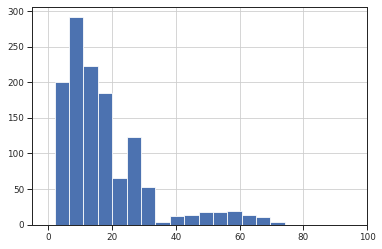

In [49]:
data.proto_id.value_counts().hist(bins=30*3)
plt.xlim(-5, 100)

In [50]:
data['energyperatom'].describe()

count    26006.000000
mean        -0.866109
std         17.087077
min       -651.575000
25%         -3.233750
50%         -2.122000
75%         -0.000250
max        896.994000
Name: energyperatom, dtype: float64

<AxesSubplot:>

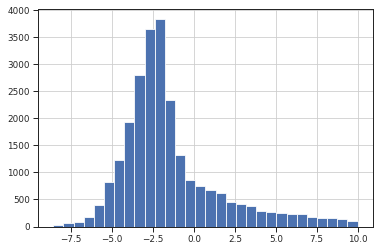

In [51]:
data = data[(data['energyperatom'] > -10) & (data['energyperatom'] < 10)]
data['energyperatom'].hist(bins=30)

In [52]:
proto_counts = data.proto_id.value_counts()
data['proto_count'] = data.proto_id.apply(lambda x: proto_counts[x])
data.head(2)

,comp_type,composition,id,energyperatom,proto_id,proto_count
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,icsd_033805,19
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092,icsd_059680,16


24674 21960


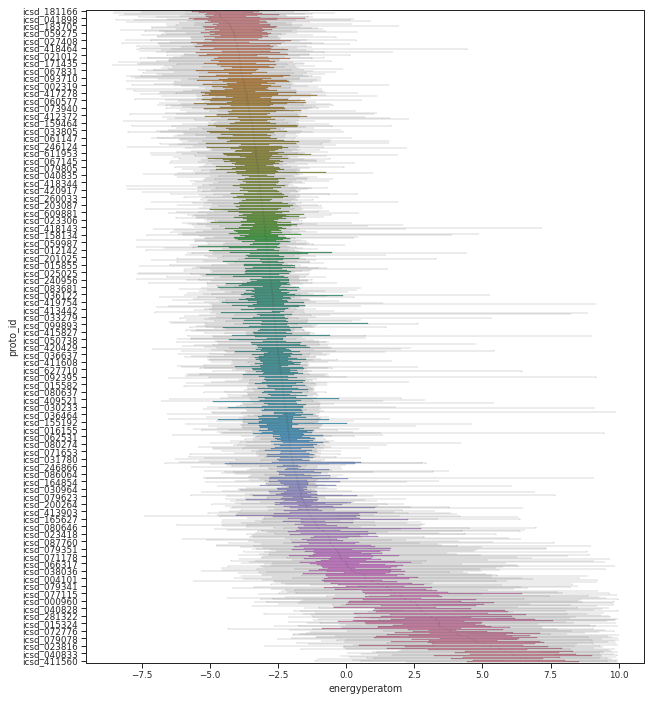

In [117]:
data2 = data[data['proto_count'] > 10]
order = data2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(data), len(data2))
sns.set_context('paper')
f, ax = plt.subplots(figsize=(10, 12))
sns.boxplot(x='energyperatom', y='proto_id', 
            data=data2,
            order=order.index,
            whis=100,
            linewidth=.2,
            ax=ax
           )
# ticks = ax.get_yticks()
ax.set_yticks(np.arange(0, len(order), 10))

plt.savefig('energyperatom_by_prototype.png', dpi=300)
plt.show()
# ticks

In [61]:
# get the protptype volume
protos_file = "/home/jlaw/projects/arpa-e/crystals/rlmolecule/rlmolecule/crystal/inputs/icsd_prototypes.json.gz"
proto_strcs = pd.DataFrame(get_structures(protos_file))
proto_strcs.columns = ['rlcrystal_id', 'structure']
proto_strcs.head(2)

  0%|          | 0/4170 [00:00<?, ?it/s]

,rlcrystal_id,structure
0,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,"[[12.70681846 1.413475 0.1000818 ] H, [4.0..."
1,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,"[[ 6.13025 9.783375 17.3280125] K, [ 6.130..."


In [77]:
proto_strcs['id'] = proto_strcs['rlcrystal_id'].apply(lambda x: 'icsd_' + x.split('_')[-1])
# proto_strcs = proto_strcs.set_index('id')
proto_strcs['volume'] = proto_strcs['structure'].apply(lambda x: x.volume)
proto_strcs['num_sites'] = proto_strcs['structure'].apply(lambda x: x.num_sites)
proto_strcs['vol_per_atom'] = proto_strcs['volume'] / proto_strcs['num_sites']
proto_strcs.head(2)

,rlcrystal_id,structure,id,volume,num_sites,vol_per_atom
0,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,"[[12.70681846 1.413475 0.1000818 ] H, [4.0...",icsd_174512,467.617802,32,14.613056
1,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,"[[ 6.13025 9.783375 17.3280125] K, [ 6.130...",icsd_079945,1712.774790,128,13.381053


In [91]:
data_proto = proto_strcs[proto_strcs['id'].isin(data2['proto_id'])]
print(len(proto_strcs), len(data_proto))

4170 873


24674 21960


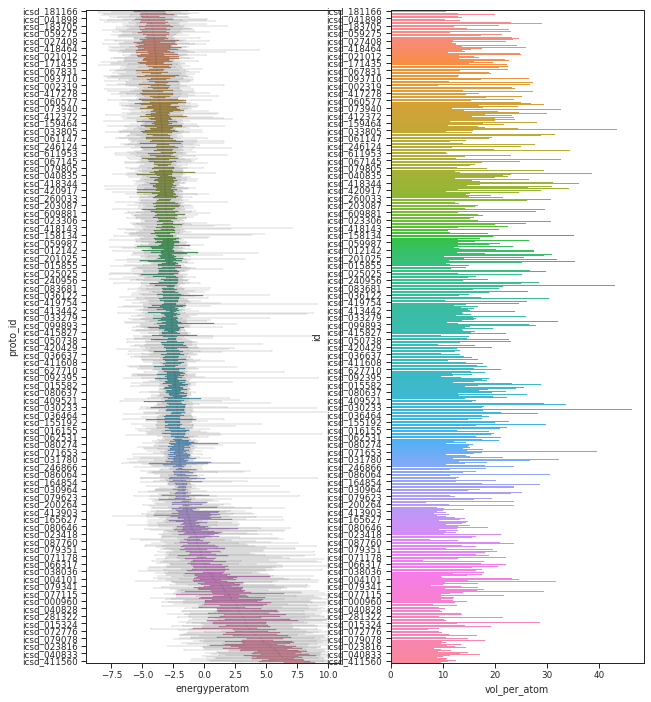

In [94]:
data2 = data[data['proto_count'] > 10]
order = data2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(data), len(data2))
sns.set_context('paper')
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(10, 12))
sns.boxplot(x='energyperatom', y='proto_id', 
            data=data2,
            order=order.index,
            whis=100,
            linewidth=.2,
            ax=ax
           )
ax.set_yticks(np.arange(0, len(order), 10))

sns.barplot(x='vol_per_atom', y='id',
           data=data_proto,
           order=order.index,
            saturation=1,
            linewidth=0,
            ax=ax2
           )
ax2.set_yticks(np.arange(0, len(data_proto), 10))
plt.show()
# ticks

In [83]:
df_volrelaxed['proto_id'] = df_volrelaxed['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
df_volrelaxed.head(2)

,id,structure,vol,num_sites,vol_per_atom,proto_id
0,Zn1La3I2P3_sg189_icsd_076297_1,"[[1.55036141 2.68529936 0. ] La, [4.580...",234.748222,9,26.083136,icsd_076297
1,Zn1La3I2P3_sg14_icsd_260350_1,"[[2.63923841 7.5685779 0.38571714] La, [6.263...",1487.586192,36,41.321839,icsd_260350


In [89]:
data = data.merge(df_volrelaxed[['id', 'vol_per_atom']], on='id')
data.head(2)

,comp_type,composition,id,energyperatom,proto_id,proto_count,vol_per_atom
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,icsd_033805,19,40.115879
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg26_icsd_059680_1,-2.092,icsd_059680,16,27.788576


In [101]:
# compute the change in volume
data = data.merge(proto_strcs[['id', 'vol_per_atom']], left_on='proto_id', right_on='id', suffixes=('', '_proto'))
data['vol_per_atom_diff'] = np.abs(data2['vol_per_atom'] - data2['vol_per_atom_proto'])
data.head(2)

,comp_type,composition,id,energyperatom,proto_id,proto_count,vol_per_atom,id_proto,vol_per_atom_proto,vol_per_atom_diff
0,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_2,-0.176,icsd_033805,19,40.115879,icsd_033805,15.776987,24.338892
1,_1_1_2_5,K5Hg1I1N2,K5Hg1I1N2_sg194_icsd_033805_1,-0.424,icsd_033805,19,39.253116,icsd_033805,15.776987,23.476129


24674 21960


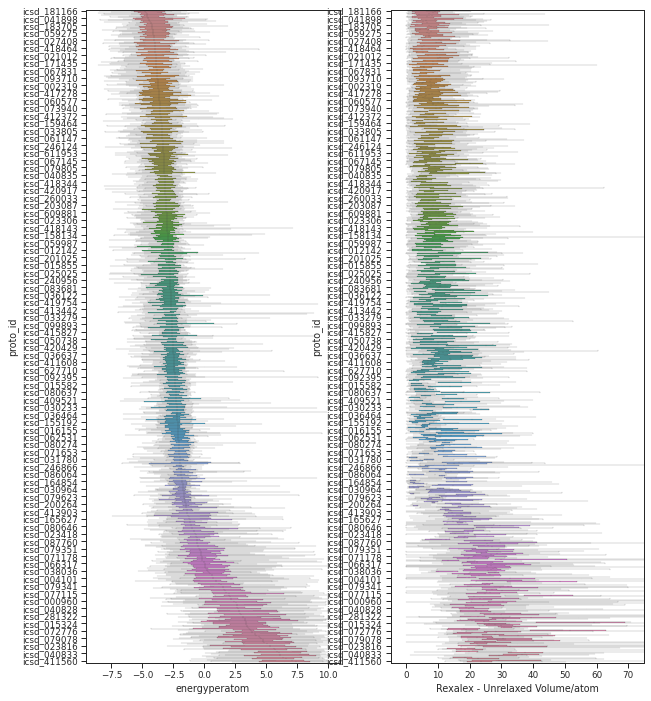

In [105]:
data2 = data[data['proto_count'] > 10]
order = data2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(data), len(data2))
sns.set_context('paper')
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(10, 12))
sns.boxplot(x='energyperatom', y='proto_id', 
            data=data2,
            order=order.index,
            whis=100,
            linewidth=.2,
            ax=ax
           )
ax.set_yticks(np.arange(0, len(order), 10))

sns.boxplot(x='vol_per_atom_diff', y='proto_id',
           data=data2,
           order=order.index,
            # saturation=1,
            linewidth=0.2,
            whis=100,
            ax=ax2
           )
ax2.set_yticks(np.arange(0, len(data_proto), 10))
ax2.set_xlim(-5, 75)
ax2.set_xlabel('Rexalex - Unrelaxed Volume/atom')
plt.show()
# ticks

In [109]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [112]:
def dss_scatter(df, x, y, ax, xrange=None, yrange=None, xlabel='', ylabel=''):
    # xrange = (0, df[x].max()) if not xrange else xrange
    # yrange = (0, df[y].max()) if not yrange else yrange
    dsshow(df, ds.Point(x, y),
       ax=ax, shade_hook=dstf.dynspread, 
           cmap='Blues', norm='eq_hist', aspect='auto', 
           y_range=yrange, x_range=xrange)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    # also compute the MAE and add it to the plot
    # mae = mean_absolute_error(df.dropna()[x], df.dropna()[y])
    # ax.text(1, 0.925, f'MAE: {mae:.1f} vol/atom',
    #     ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

In [119]:
sns.set_context('talk')

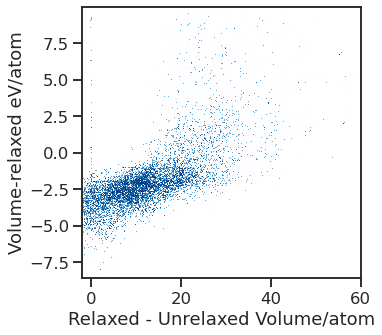

In [122]:
data['vol_per_atom_diff_noabs'] = data2['vol_per_atom'] - data2['vol_per_atom_proto']
f, ax = plt.subplots(figsize=(5,5))
dss_scatter(data, 
            'vol_per_atom_diff_noabs', 'energyperatom', ax, 
            xrange=(-2, 60), yrange=None, 
            xlabel='Relaxed - Unrelaxed Volume/atom', 
            ylabel='Volume-relaxed eV/atom')


In [155]:
data.head(2)

,comp_type,composition,energyperatom,proto_id,proto_count,vol_per_atom,id_proto,vol_per_atom_proto,vol_per_atom_diff,vol_per_atom_diff_noabs,energyperatom_full_relax
id,,,,,,,,,,,
K5Hg1I1N2_sg194_icsd_033805_2,_1_1_2_5,K5Hg1I1N2,-0.176,icsd_033805,19,40.115879,icsd_033805,15.776987,24.338892,24.338892,NaN
K5Hg1I1N2_sg194_icsd_033805_1,_1_1_2_5,K5Hg1I1N2,-0.424,icsd_033805,19,39.253116,icsd_033805,15.776987,23.476129,23.476129,NaN


In [157]:
# pull out the structures where relaxed - unrel volume ~= 0, and ev/atom > 0
no_vol_diff = data[(data['vol_per_atom_diff'] < 0.1) & (data['energyperatom'] > 0)][['comp_type', 'composition', 'energyperatom', 'proto_id', 'vol_per_atom', 'vol_per_atom_diff_noabs']]
no_vol_diff.comp_type.value_counts()

_1_1_1_7      14
_1_1_1_2_2    10
_1_2_2_3       9
_1_2_5         8
_1_1_3_3       8
_1_3_3_3       6
_1_1_1_3_3     6
_1_1_1_2_4     5
_1_3_3         5
_1_1_2_2_3     5
_1_1_4_4       3
_1_3           3
_1_1_2_3       3
_1_1_2_2_4     2
_1_2_2_2_2     2
_1_4_5         2
_1_1_1_2_3     2
_1_1_5         2
_1_2_2_5       2
_1_2_2_4       2
_1_1_2_4       2
_1_1_1_1_2     1
_1_1_3_5       1
_1_2_6         1
_1_1_8         1
_1_3_6         1
_1_4_4         1
_1_1_7         1
_1_1_1_5       1
_1_2_3_3       1
Name: comp_type, dtype: int64

In [158]:
no_vol_diff.to_csv('no_vol_diff.csv')

<AxesSubplot:>

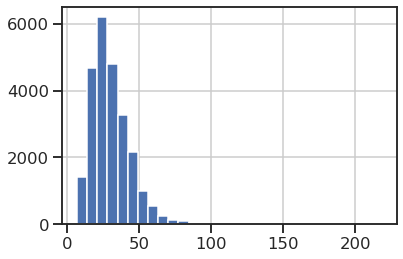

In [125]:
data['vol_per_atom'].hist(bins=30)

<AxesSubplot:>

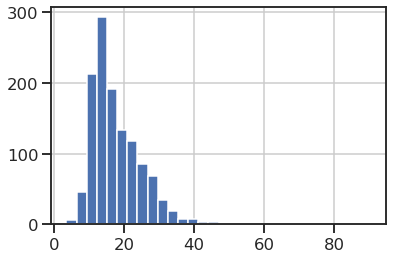

In [124]:
data.groupby('proto_id').mean()['vol_per_atom_proto'].hist(bins=30)

In [131]:
strcs = [
    'K4B1I4N1_sg215_icsd_414557_2',
    'K3P1_sg221_icsd_167837_1',
    'K3P1_sg166_icsd_028783_1',
    'K3P1_sg221_icsd_025596_1',
    'K3N1_sg221_icsd_167837_1',
    'Mg3Br3N1_sg223_icsd_611953_1',
]
data[data['id'].isin(strcs)][['id', 'vol_per_atom', 'vol_per_atom_proto']]


,id,vol_per_atom,vol_per_atom_proto
15873,K4B1I4N1_sg215_icsd_414557_2,67.912362,16.022688
20070,K3N1_sg221_icsd_167837_1,30.661607,13.342431
20071,K3P1_sg221_icsd_167837_1,40.299255,13.342431
20077,K3P1_sg221_icsd_025596_1,43.080360,14.863999
20193,K3P1_sg166_icsd_028783_1,42.437007,14.506073
23035,Mg3Br3N1_sg223_icsd_611953_1,24.540132,10.573992


## Compare the eV/atom per prototype for the fully relaxed structures as well

In [143]:
calc_energy['proto_id'] = calc_energy['id'].apply(lambda x: 'icsd_' + x.split('_')[-2])
proto_counts = calc_energy.proto_id.value_counts()
calc_energy['proto_count'] = calc_energy.proto_id.apply(lambda x: proto_counts[x])
calc_energy.head(2)

,comp_type,composition,id,energyperatom,proto_id,proto_count
0,112,Mg2Cl1P1,Mg2Cl1P1_sg2_icsd_035676_1,-3.527097,icsd_035676,28
1,112,Mg2Cl1P1,Mg2Cl1P1_sg55_icsd_642437_1,-3.365935,icsd_642437,21


In [137]:
data = data.set_index('id')
data['energyperatom_full_relax'] = calc_energy.set_index('id')['energyperatom']

In [139]:
data.head(2)

,comp_type,composition,energyperatom,proto_id,proto_count,vol_per_atom,id_proto,vol_per_atom_proto,vol_per_atom_diff,vol_per_atom_diff_noabs,energyperatom_full_relax
id,,,,,,,,,,,
K5Hg1I1N2_sg194_icsd_033805_2,_1_1_2_5,K5Hg1I1N2,-0.176,icsd_033805,19,40.115879,icsd_033805,15.776987,24.338892,24.338892,NaN
K5Hg1I1N2_sg194_icsd_033805_1,_1_1_2_5,K5Hg1I1N2,-0.424,icsd_033805,19,39.253116,icsd_033805,15.776987,23.476129,23.476129,NaN


24674 21960
67840 60332


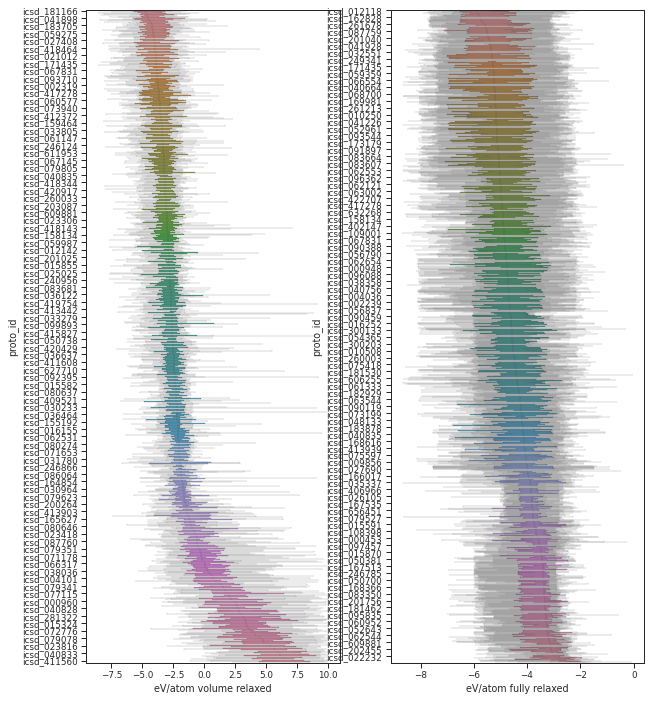

In [145]:
data2 = data[data['proto_count'] > 10]
order = data2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(data), len(data2))
sns.set_context('paper')
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(10, 12))
sns.boxplot(x='energyperatom', y='proto_id', 
            data=data2,
            order=order.index,
            whis=100,
            linewidth=.2,
            ax=ax
           )
ax.set_yticks(np.arange(0, len(order), 10))
ax.set_xlabel('eV/atom volume relaxed')


calc_energy2 = calc_energy[calc_energy['proto_count'] > 10]
# order = calc_energy2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(calc_energy), len(calc_energy2))
sns.boxplot(x='energyperatom', y='proto_id',
           data=calc_energy2,
           order=order.index,
            # saturation=1,
            linewidth=0.2,
            whis=100,
            ax=ax2
           )
ax2.set_yticks(np.arange(0, len(order), 20))
ax2.set_xlabel('eV/atom fully relaxed')
plt.show()

24674 21960
67840 60332


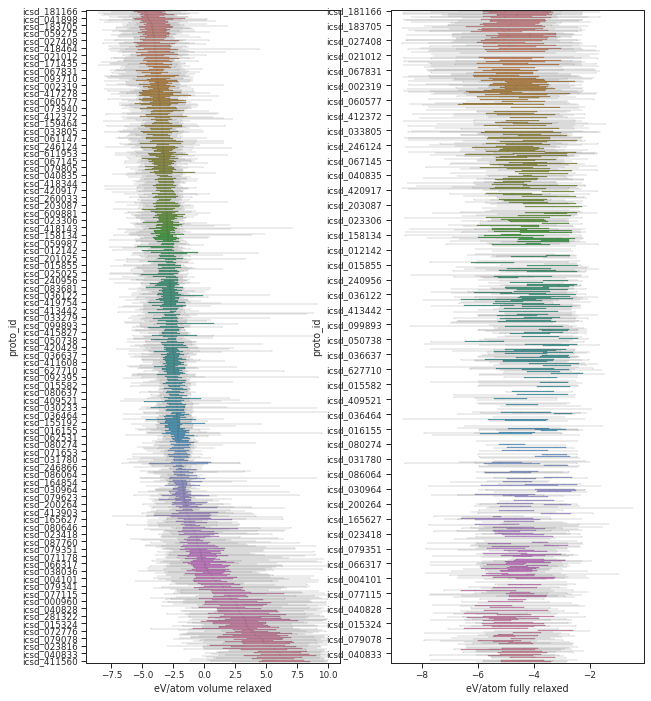

In [159]:
data2 = data[data['proto_count'] > 10]
order = data2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(data), len(data2))
sns.set_context('paper')
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(10, 12))
sns.boxplot(x='energyperatom', y='proto_id', 
            data=data2,
            order=order.index,
            whis=100,
            linewidth=.2,
            ax=ax
           )
ax.set_yticks(np.arange(0, len(order), 10))
ax.set_xlabel('eV/atom volume relaxed')


calc_energy2 = calc_energy[calc_energy['proto_count'] > 10]
# order = calc_energy2.groupby('proto_id')['energyperatom'].median().sort_values()
print(len(calc_energy), len(calc_energy2))
sns.boxplot(x='energyperatom', y='proto_id',
           data=calc_energy2,
           order=order.index,
            # saturation=1,
            linewidth=0.2,
            whis=100,
            ax=ax2
           )
ax2.set_yticks(np.arange(0, len(order), 20))
ax2.set_xlabel('eV/atom fully relaxed')
plt.show()

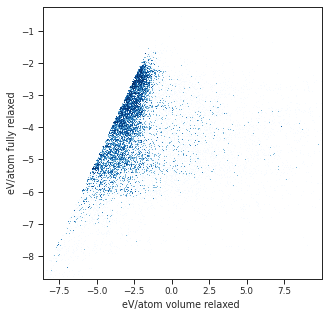

In [146]:
f, ax = plt.subplots(figsize=(5,5))
dss_scatter(data, 
            'energyperatom', 'energyperatom_full_relax', ax, 
            # xrange=(-2, 60), yrange=None, 
            ylabel='eV/atom fully relaxed', 
            xlabel='eV/atom volume relaxed ')
